#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DummyRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#DecisionTreeRegressor" data-toc-modified-id="DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>DecisionTreeRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

RANDOM_STATE=42

## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.sort_index(inplace=True)

In [4]:
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
df.index.isna().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Вывод
- Данные выгружены и отсортированы
- Пропуски в данных отсутствуют
- Временной отреезок: с 2018-03-01 00:00:00 до 2018-08-31 23:50:00

## Анализ

Выполним ресемплирование данных по одному часу.

In [7]:
df = df.resample('1H').sum()

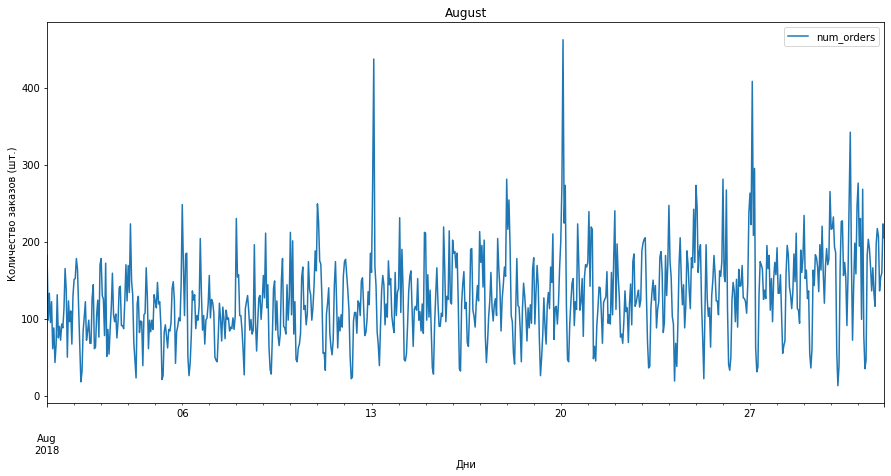

In [8]:
df['2018-08':'2018-09'].plot(title='August', figsize=(15,7), xlabel='Дни', ylabel='Количество заказов (шт.)');

Рассмотрим тренд, сезонность и остаток декомпозиции данных

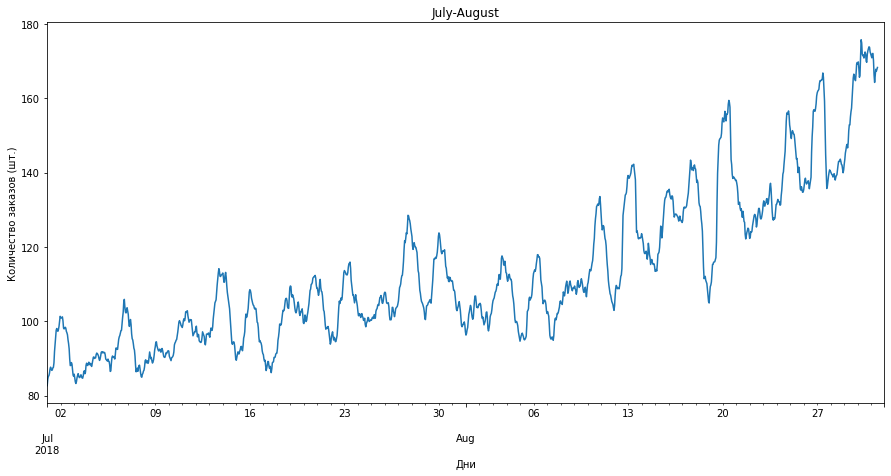

In [9]:
dec_df = seasonal_decompose(df)
dec_df.trend['2018-07':'2018-09'].plot(title='July-August', figsize=(15,7), xlabel='Дни', ylabel='Количество заказов (шт.)');

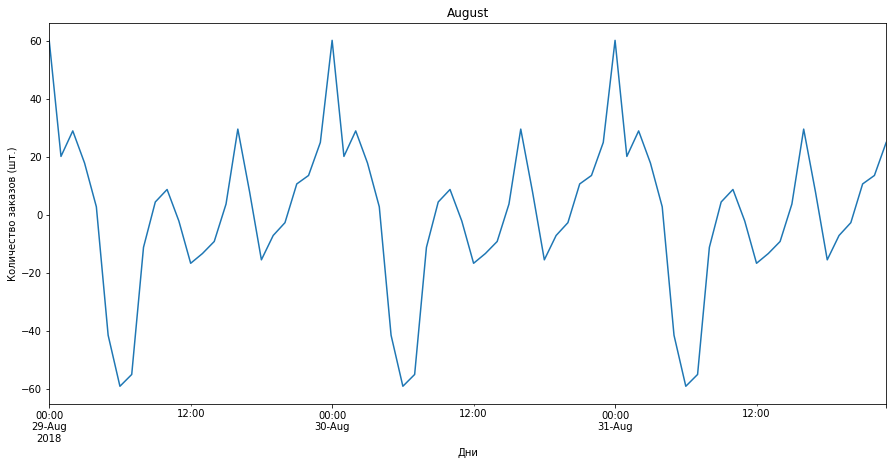

In [10]:
dec_df.seasonal['2018-08-29':'2018-09'].plot(title='August', figsize=(15,7), xlabel='Дни', ylabel='Количество заказов (шт.)');

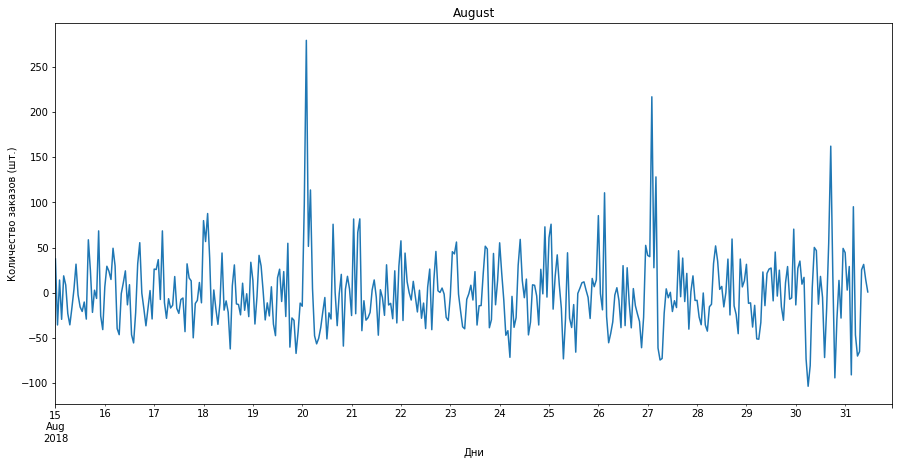

In [11]:
dec_df.resid['2018-08-15':'2018-09'].plot(title='August', figsize=(15,7), xlabel='Дни', ylabel='Количество заказов (шт.)');

In [12]:
tmp = df['num_orders'].to_frame()
tmp['SMA30'] = tmp['num_orders'].rolling(30, closed='left').mean()

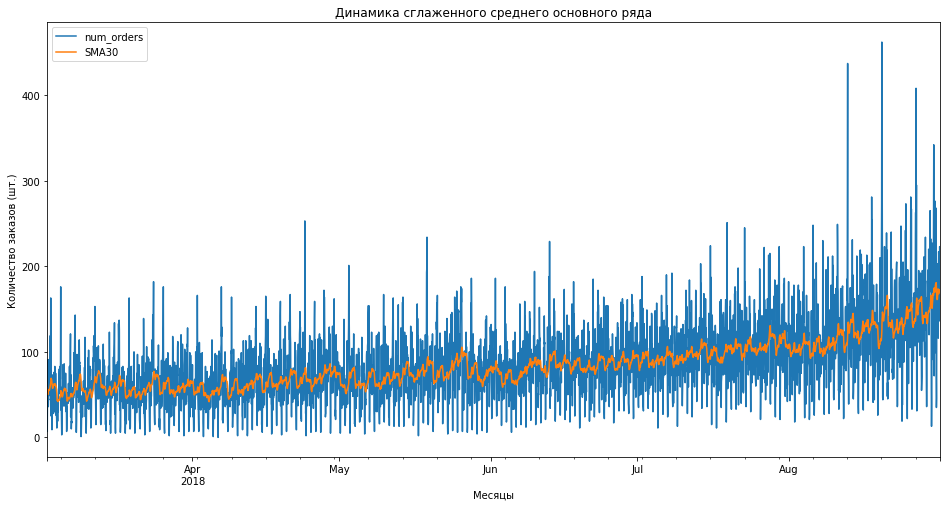

In [13]:
tmp.dropna(inplace=True)
tmp.plot(title='Динамика сглаженного среднего основного ряда', figsize=(16, 8), 
         xlabel='Месяцы', ylabel='Количество заказов (шт.)');

На графике видно, что сглаженное среднее увеличивается со временем, поэтому можем подозревать отсутствие стационарности временного ряда. Проведем тест Дики-Фуллера, чтобы проверить гипотезу.

Проверка на стационарность ряда с помощью расширенного теста Дики-Фуллера на уровне значимости 0.01: <br>
$H_0$ : Временной ряд является нестационарным.<br>
$H_1$ : Bременной ряд является стационарным.

In [14]:
if (adfuller(df['num_orders'])[1] < 0.01):
    print('Нулевая гипотеза отвергается')
else:
    print('Нулевая гипотеза не отвергается')

Нулевая гипотеза не отвергается


Создадим признаки для обучения модели

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data_func = data.copy()
    data_func['day'] = data_func.index.day
    data_func['dayofweek'] = data_func.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_func['lag_{}'.format(lag)] = data_func['num_orders'].shift(lag)

    data_func['rolling_mean'] = data_func['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_func

In [16]:
features_data = make_features(df, 24, 100)

In [17]:
features_data.tail()

,num_orders,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 19:00:00,136,31,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,157.33
2018-08-31 20:00:00,154,31,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,156.74
2018-08-31 21:00:00,159,31,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,156.63
2018-08-31 22:00:00,223,31,4,159.0,154.0,136.0,207.0,217.0,197.0,116.0,...,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,156.40
2018-08-31 23:00:00,205,31,4,223.0,159.0,154.0,136.0,207.0,217.0,197.0,...,46.0,35.0,78.0,268.0,99.0,230.0,194.0,276.0,246.0,157.52


### Вывод
- Тренд увеличивается, значит, растет популярность и количество пользователей;
- Утром количество заказов резко уменьшается, далее возрастает, имеет провал в полдень и два пика в 15.00 и в полночь;
- Момент самого высокого спроса - полночь;
- Момент самого низкого спроса - 06.00;
- Сглаженное среднее увеличивается со временем. На тесте Дики-Фуллера нулевая гипотеза была отвергнута. Значит, ряд нестационарен;
- Были создвны признаки для обучения модели.

## Обучение

In [18]:
train, test = train_test_split(features_data, shuffle=False, test_size=0.1, random_state=1515)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

In [19]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict)) ** 0.5
   
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### DummyRegressor

In [20]:
model = DummyRegressor(strategy='mean').fit(features_train, target_train)
y_pred = model.predict(features_train)

cv_RMSE_DR = RMSE(target_train, y_pred)
print('DecisionTreeRegressor CV RMSE:', cv_RMSE_DR)

DecisionTreeRegressor CV RMSE: 38.669691200940626


### LinearRegression

In [21]:
cv_RMSE_LR = round((cross_val_score(LinearRegression(),
                                features_train, 
                                target_train, 
                                cv=TimeSeriesSplit(n_splits=3).split(features_train), 
                                scoring=RMSE_score)).mean() * -1, 3)
                
print('LinearRegression CV RMSE:', cv_RMSE_LR)

LinearRegression CV RMSE: 28.663


### DecisionTreeRegressor

In [22]:
clf_dt = GridSearchCV(DecisionTreeRegressor(random_state=RANDOM_STATE), 
                      [{'max_depth': [x for x in range(2, 15)]}], 
                      cv=TimeSeriesSplit(n_splits=3).split(features_train), scoring=RMSE_score)
clf_dt.fit(features_train, target_train)

cv_RMSE_DTR = round(clf_dt.best_score_ * -1, 3)
print('DecisionTreeRegressor CV RMSE:', cv_RMSE_DTR)

DecisionTreeRegressor CV RMSE: 31.473


### CatBoostRegressor

In [23]:
clf_cb = GridSearchCV(CatBoostRegressor(random_state=RANDOM_STATE, verbose=False), 
                      [{'learning_rate': [0.1, 0.2, 0.3]}], 
                      cv=TimeSeriesSplit(n_splits=3).split(features_train), scoring=RMSE_score)
clf_cb.fit(features_train, target_train)

cv_RMSE_CBR = round(clf_cb.best_score_ * -1, 3)
print('CatBoostRegressor CV RMSE:', cv_RMSE_CBR)

CatBoostRegressor CV RMSE: 26.977


### LGBMRegressor

In [24]:
clf_lgbm = GridSearchCV(LGBMRegressor(random_state=RANDOM_STATE), 
                        [{'learning_rate':[x/10 for x in range(1, 6)]}], 
                        cv=TimeSeriesSplit(n_splits=3).split(features_train), scoring=RMSE_score)
clf_lgbm.fit(features_train, target_train)

cv_RMSE_LGBMR = round(clf_lgbm.best_score_ * -1, 3)
print('LGBMRegressor CV RMSE:', cv_RMSE_LGBMR)

LGBMRegressor CV RMSE: 27.689


### Вывод
- Было обучено 5 моделей: DummyRegressor, LinearRegression, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor
- Лучший результат на кросс-валидации показала модель CatBoostRegressor

## Тестирование

In [25]:
def time_test(model, features_train, target_train, rmse):
    fit_time = time.time()
    model.fit(features_train, target_train)
    fit_time_2 = time.time()

    pred_time = time.time()
    target_predict = model.predict(features_train)
    pred_time_2 = time.time()

    return [round(fit_time_2 - fit_time, 4), round(pred_time_2 - pred_time, 4), rmse]

In [26]:
dr_info = time_test(DummyRegressor(strategy='mean'), features_train, target_train, cv_RMSE_DR)
lr_info = time_test(LinearRegression(), features_train, target_train, cv_RMSE_LR)
dt_info = time_test(DecisionTreeRegressor(max_depth=4, random_state=42), features_train, target_train, cv_RMSE_DTR)
cb_info = time_test(CatBoostRegressor(learning_rate=0.1, random_state=42, verbose=False), features_train, target_train, cv_RMSE_CBR)
lgbm_info = time_test(LGBMRegressor(learning_rate=0.1, random_state=42), features_train, target_train, cv_RMSE_LGBMR)

In [27]:
result = pd.DataFrame(data=[dr_info, lr_info, dt_info, cb_info, lgbm_info], 
                      index=["DummyRegressor", "LinearRegression", "DecisionTreeRegressor", 
                             "CatBoostRegressor", "LGBMRegressor"], 
                      columns=["fit_time", "predict_time", "RMSE"])
result.sort_values('RMSE', ascending=True)

,fit_time,predict_time,RMSE
CatBoostRegressor,7.5163,0.0057,26.977000
LGBMRegressor,3.3577,0.0076,27.689000
LinearRegression,0.0065,0.0920,28.663000
DecisionTreeRegressor,0.1210,0.0024,31.473000
DummyRegressor,0.0004,0.0002,38.669691


In [28]:
best_model = CatBoostRegressor(learning_rate=0.1, random_state=42, verbose=False).fit(features_train, target_train)
target_predict = best_model.predict(features_test)
print('RMSE лучшей модели на тестовой выборке:', RMSE(target_test, target_predict))

RMSE лучшей модели на тестовой выборке: 40.859432266754375


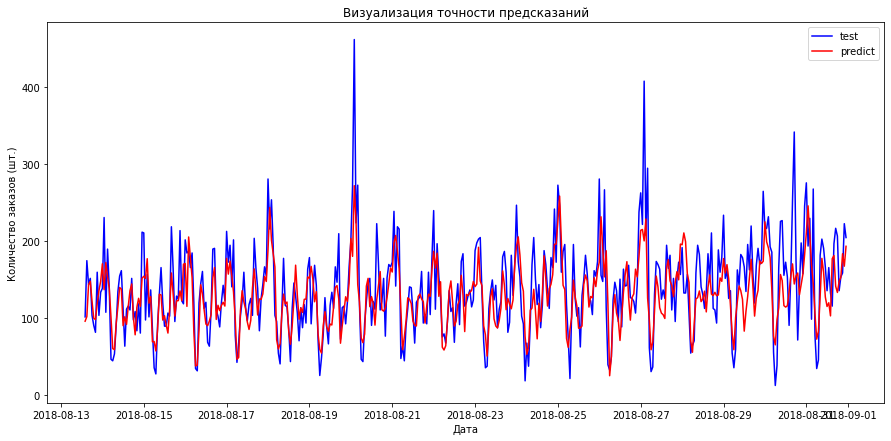

In [29]:
plt.figure(figsize=(15, 7))
plt.plot(target_test.index, 
         target_test, 
         'b-', label='test')
plt.plot(target_test.index, 
         target_predict,
         'r-', label='predict')
plt.xlabel('Дата')
plt.ylabel('Количество заказов (шт.)')
plt.title('Визуализация точности предсказаний')
plt.legend()
plt.show()

## Вывод
- По времени и RMSE лучшей моделью оказалась LinearRegression. На тестовой выборке она показала ошибку, равную 40, что является меньше 48. Условия заказчика выполнены;
- Данные были выгружены и отсортированы;
- Пропуски в данных отсутствуют;
- Временной отреезок: с 2018-03-01 00:00:00 до 2018-08-31 23:50:00;
- Тренд увеличивается, значит, растет популярность и количество пользователей;
- Утром количество  заказов резко уменьшается, далее возрастает, имеет провал в полдень и два пика в 15.00 и в полночь;
- Момент самого высокого спроса - полночь;
- Момент самого низкого спроса - 06.00;
- Сглаженное среднее увеличивается со временем. На тесте Дики-Фуллера нулевая гипотеза была отвергнута. Значит, ряд нестационарен;
- Тренд увеличивается, значит, растет популярность и количество пользователей;
- Утром количество заказов резко уменьшается, далее возрастает, имеет провал в полдень и два пика в 15.00 и в полночь;
- Момент самого высокого спроса - полночь;
- Момент самого низкого спроса - 06.00;
- Были создвны признаки для обучения модели;
- Было обучено 5 моделей: DummyRegressor, LinearRegression, DecisionTreeRegressor, CatBoostRegressor, LGBMRegressor
- Лучший результат на кросс-валидации показала модель CatBoostRegressor